In [1]:
import numpy as np
import dxchange
import holotomo
import tifffile
import matplotlib.pyplot as plt
import sys
import h5py
PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline


# Init data sizes and parametes of the PXM of ID16A

In [2]:
energy = 25.51  # [keV] xray energy
voxelsize = 0.92*1e-6
ndist = 1

use_prb = False
use_code = False
flg_show = True
###################

ne = 1024
n = 1024  # object size in each dimension
ntheta = 1  # number of angles (rotations)
pn = 1024 # tomography chunk size for GPU processing
ptheta = 1  # holography chunk size for GPU processing
center = n/2  # rotation axis

wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
distances = np.array([0.7])
magnifications = np.array([1])

norm_magnifications = magnifications


## Read data

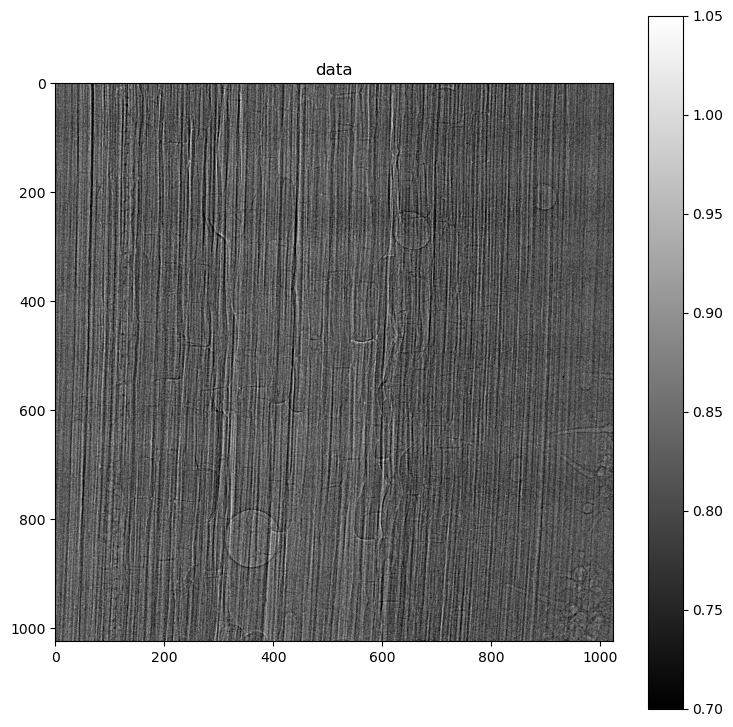

In [3]:
data = np.zeros([ndist,ntheta,n,n],dtype='float32')
with h5py.File('/data/2022-12/Finfrock-2022-12/SM20220926_4_C1_028.h5','r') as fid:
    data0=fid['exchange/data'][0:1]    
    dark0=fid['exchange/data_dark'][:]
    ref0=fid['exchange/data_white'][:]
data[0] = data0[:,data0.shape[1]//2-n//2:data0.shape[1]//2+n//2,data0.shape[2]//2-n//2:data0.shape[2]//2+n//2]
dark = dark0[:,   data0.shape[1]//2-n//2:data0.shape[1]//2+n//2,data0.shape[2]//2-n//2:data0.shape[2]//2+n//2]
ref = ref0[:,     data0.shape[1]//2-n//2:data0.shape[1]//2+n//2,data0.shape[2]//2-n//2:data0.shape[2]//2+n//2]
data[:] = (data-np.mean(dark,axis=0))/(np.mean(ref,axis=0)-np.mean(dark,axis=0))
if flg_show:
    fig, axs = plt.subplots(1, figsize=(9, 9))
    im=axs.imshow(data[0,0],cmap='gray',vmin=0.7,vmax=1.05)

    axs.set_title('data')
    fig.colorbar(im)
    plt.show()

ref[:] = 1

## Read the transmittance functions for the code

## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [4]:
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications)

In [5]:
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')
prb1 = np.array(ref*0+1).astype('complex64')
arr2 = pslv.fwd_holo_batch(arr1, prb1)
arr3 = pslv.adj_holo_batch(arr2, prb1)
print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))


(1411240.2-0.000117849675j)
(1411240.1+1.725635e-05j)


## Conjugate gradient solver

1


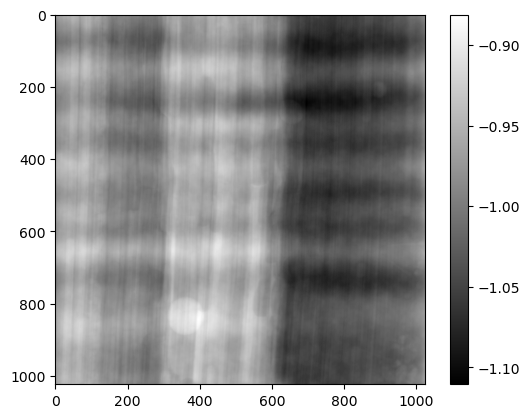

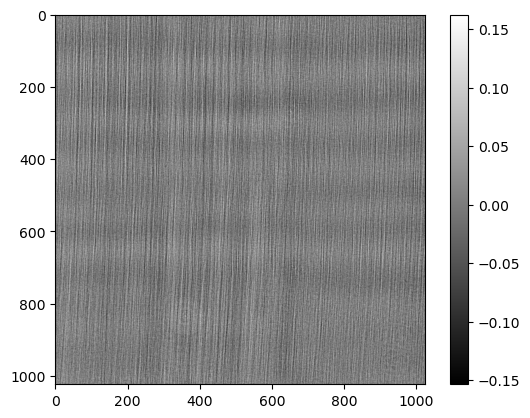

In [6]:
def CTFPurePhase(rads, wlen, dists, fx, fy, alpha):
   """
   weak phase approximation from Cloetens et al. 2002




   Parameters
   ----------
   rad : 2D-array
       projection.
   wlen : float
       X-ray wavelentgth assumes monochromatic source.
   dist : float
       Object to detector distance (propagation distance) in mm.
   fx, fy : ndarray
       Fourier conjugate / spatial frequency coordinates of x and y.
   alpha : float
       regularization factor.
       
   Return
   ------
   phase retrieved projection in real space
   """    
   numerator = 0
   denominator = 0    
   for j in range(0, len(dists)):    
       rad_freq = np.fft.fft2(rads[j])
       taylorExp = np.sin(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
       numerator = numerator + taylorExp * (rad_freq)
       denominator = denominator + 2*taylorExp**2 
   numerator = numerator / len(dists)
   denominator = (denominator / len(dists)) + alpha
   phase = np.real(  np.fft.ifft2(numerator / denominator) )
   phase = 0.5 * phase
   return phase

def multiPaganin(rads, wlen, dists, delta_beta, fx, fy, alpha):
    """
    Phase retrieval method based on Contrast Transfer Function. This 
    method relies on linearization of the direct problem, based  on  the
    first  order  Taylor expansion of the transmittance function.
    Found in Yu et al. 2018 and adapted from Cloetens et al. 1999


    Parameters
    ----------
    rad : 2D-array
        projection.
    wlen : float
        X-ray wavelentgth assumes monochromatic source.
    dist : float
        Object to detector distance (propagation distance) in mm.
    delta : float    
        refractive index decrement
    beta : float    
        absorption index
    fx, fy : ndarray
        Fourier conjugate / spatial frequency coordinates of x and y.
    alpha : float
        regularization factor.
        
    Return
    ------

    phase retrieved projection in real space
    """    
    numerator = 0
    denominator = 0    
    for j in range(0, len(dists)):    
        rad_freq = np.fft.fft2(rads[j])    
        taylorExp = 1 + wlen * dists[j] * np.pi * (delta_beta) * (fx**2+fy**2)
        numerator = numerator + taylorExp * (rad_freq)
        denominator = denominator + taylorExp**2 

    numerator = numerator / len(dists)
    denominator = (denominator / len(dists)) + alpha

    phase = np.log(np.real(  np.fft.ifft2(numerator / denominator) ))    
    phase = (delta_beta) * 0.5 * phase

    
    return phase

distances_rec = (distances/norm_magnifications**2)[:ndist]

fx = np.fft.fftfreq(n,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)

wlen = 1.24e-9/energy
recCTFPurePhase = np.zeros([ntheta,n,n],dtype='complex64')
recMultiPaganin = np.zeros([ntheta,n,n],dtype='complex64')
print(ndist)
for k in range(ntheta):
    rads = data[:ndist,k]
    # recCTFPurePhase[k] = np.exp(1j*CTFPurePhase(rads, wlen, distances_rec, fx, fy, 1e-3))
    recCTFPurePhase[k] = np.exp(1j*CTFPurePhase(rads, wlen, distances_rec, fx, fy, 1e-2))
    recMultiPaganin[k] = np.exp(1j*multiPaganin(rads, wlen, distances_rec, 10, fx, fy, 1e-12))
if flg_show:
    plt.imshow(np.angle(recMultiPaganin[0]),cmap='gray')
    plt.colorbar()
    plt.show()
    plt.imshow(np.angle(recCTFPurePhase[0]),cmap='gray')
    plt.colorbar()
    plt.show()




In [7]:
import cupy as cp
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd,) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo(pslv, data, init, init_prb,  piter, step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    data = cp.sqrt(data)
    # minimization functional
    def minf(fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    for i in range(piter):
        fpsi = pslv.fwd_holo(psi,prb)  
        
        grad = pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb)
        if i == 0:
            d = -grad
        else:
            d = -grad+cp.linalg.norm(grad)**2 / \
                ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad

        fd = pslv.fwd_holo(d, prb)
        gammapsi = line_search(minf, gammapsi0, fpsi, fd)
        psi = psi+gammapsi*d
        # plt.imshow(np.abs(psi[0].get()),cmap='gray')
        # plt.colorbar()
        # plt.show()
        
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb)
            err=minf(fprb)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)  

        
        elif i%vis_step==0:
            if flg_show:  
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(cp.abs(psi[0,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]).get(),cmap='gray')
                axs[0].set_title('reconstructed amplitude')
                fig.colorbar(im)
                im=axs[1].imshow(cp.angle(psi[0,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]).get(),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/plant/{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/plant/{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
                        
            
    return psi,prb

def cg_holo_batch(pslv, data, init, prb_init, piter,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
                        
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, data_gpu, init_gpu,prb_init_gpu, piter,step,vis_step,gammapsi0,gammaprb0)        
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb



0) gammapsi=0.5 gammaprb=1, err=2.56006e+03
4) gammapsi=0.5 gammaprb=1, err=2.36298e-08
8) gammapsi=0.5 gammaprb=1, err=2.67362e-08
12) gammapsi=0.25 gammaprb=1, err=4.92623e-08
16) gammapsi=0.5 gammaprb=1, err=2.44783e-08


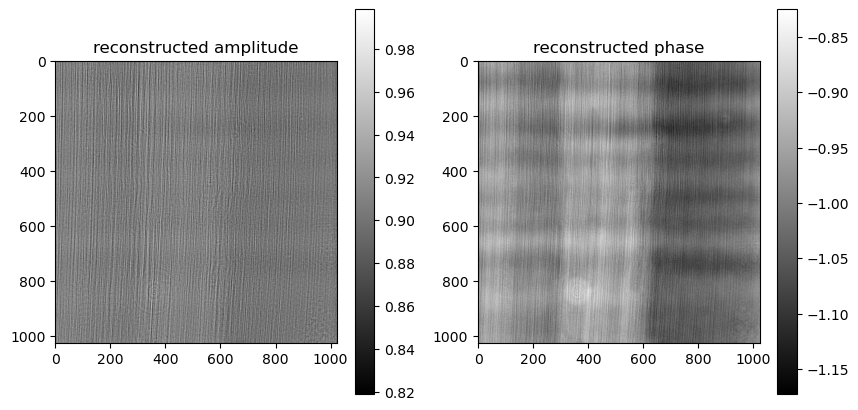

20) gammapsi=0.5 gammaprb=1, err=2.97962e-08
24) gammapsi=0.5 gammaprb=1, err=1.82658e-08
28) gammapsi=0.25 gammaprb=1, err=3.42189e-08
32) gammapsi=0.5 gammaprb=1, err=2.48118e-08


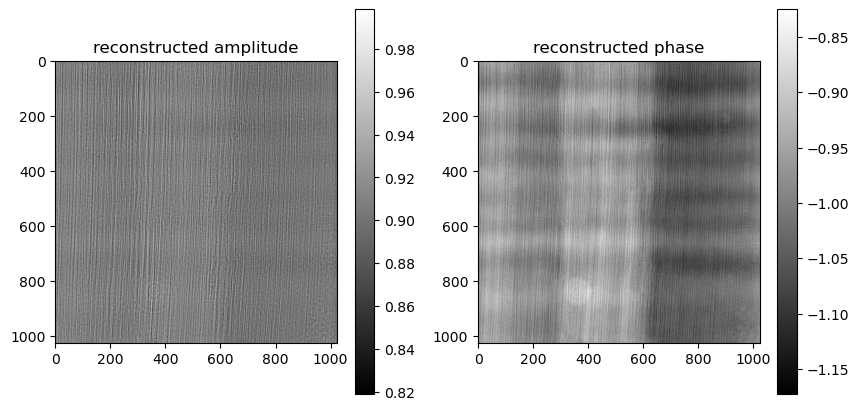

36) gammapsi=0.5 gammaprb=1, err=3.68191e-08
40) gammapsi=0.5 gammaprb=1, err=3.21080e-08
44) gammapsi=0.5 gammaprb=1, err=3.60492e-08
48) gammapsi=0.5 gammaprb=1, err=2.73460e-08


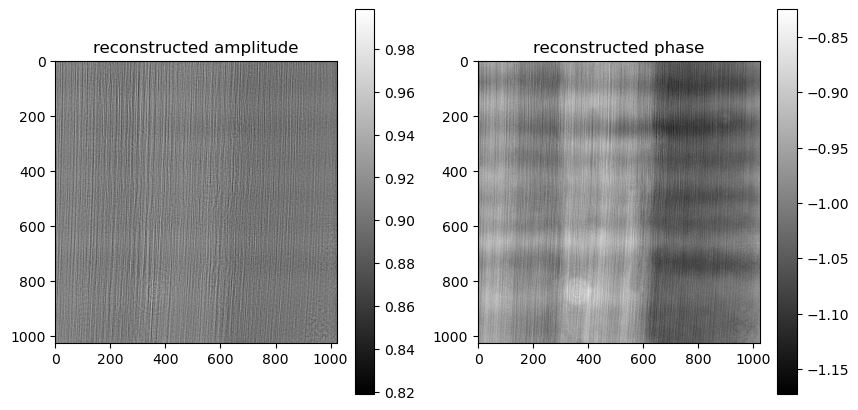

52) gammapsi=0.5 gammaprb=1, err=3.74287e-08
56) gammapsi=0.5 gammaprb=1, err=2.12697e-08
60) gammapsi=0.5 gammaprb=1, err=2.60855e-08
64) gammapsi=0.5 gammaprb=1, err=2.39871e-08
68) gammapsi=0.5 gammaprb=1, err=2.79101e-08
72) gammapsi=0.5 gammaprb=1, err=2.06839e-08
76) gammapsi=0.5 gammaprb=1, err=2.26079e-08
80) gammapsi=0.5 gammaprb=1, err=2.66496e-08
84) gammapsi=0.5 gammaprb=1, err=3.15182e-08


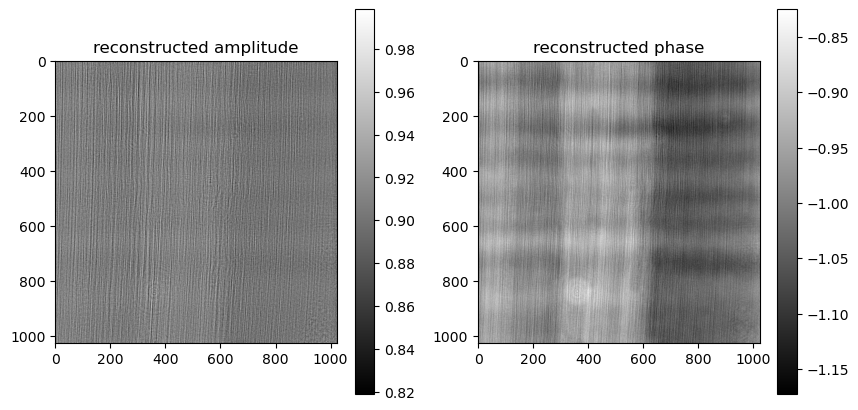

88) gammapsi=0.5 gammaprb=1, err=2.11613e-08
92) gammapsi=0.5 gammaprb=1, err=2.45793e-08
96) gammapsi=0.5 gammaprb=1, err=2.76844e-08
100) gammapsi=0.5 gammaprb=1, err=2.03708e-08


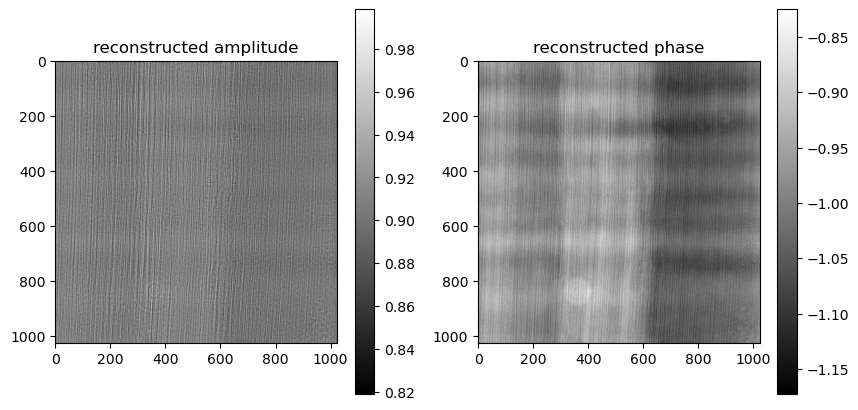

104) gammapsi=0.5 gammaprb=1, err=1.91045e-08
108) gammapsi=0.5 gammaprb=1, err=2.24840e-08
112) gammapsi=0.5 gammaprb=1, err=2.60267e-08
116) gammapsi=0.5 gammaprb=1, err=3.37987e-08


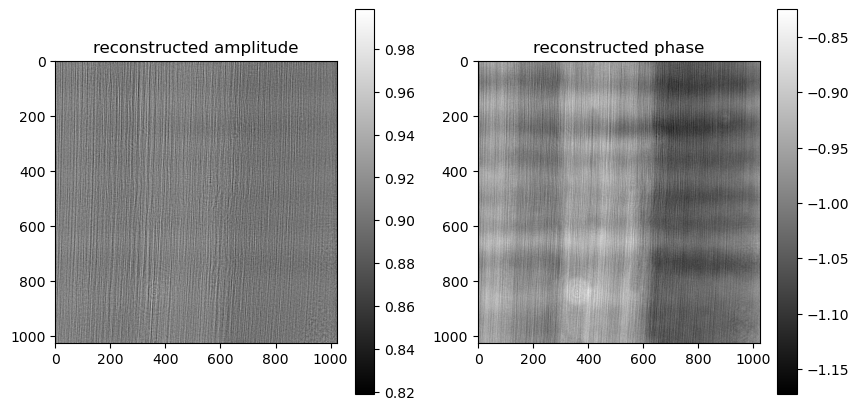

120) gammapsi=0.5 gammaprb=1, err=2.34598e-08
124) gammapsi=0.5 gammaprb=1, err=2.33876e-08
128) gammapsi=0.5 gammaprb=1, err=5.41997e-08


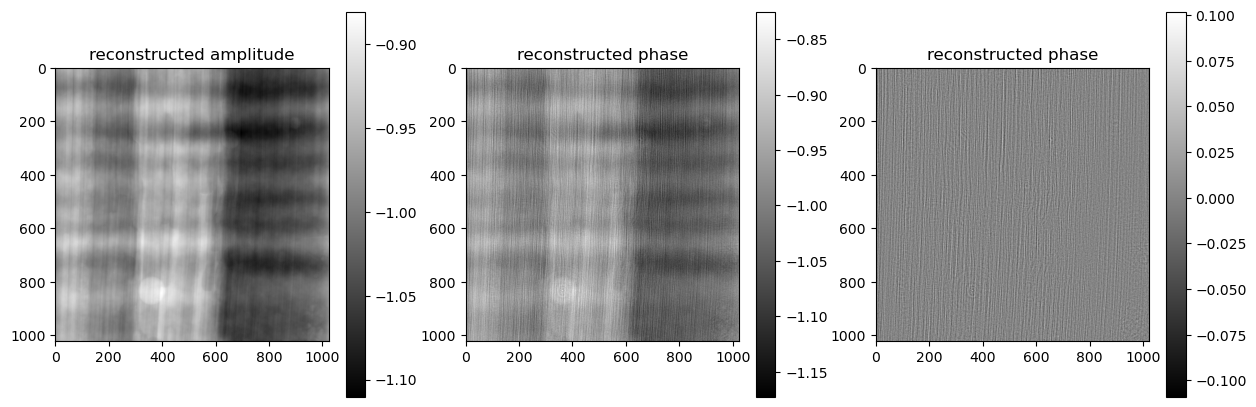

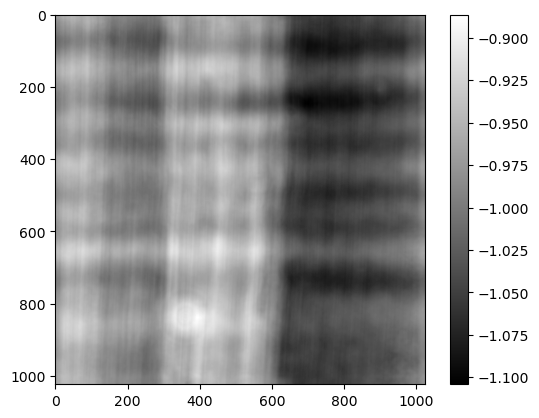

In [8]:
rec1 = recMultiPaganin.copy()
rec_prb1 = np.ones([ndist,n,n],dtype='complex64')
# plt.imshow(np.abs(code[0]))
# print(data.dtype)
rec1,rec_prb1 = cg_holo_batch(pslv, data, rec1, rec_prb1, 129, 4,17,0.5,1)  
                            #(pslv, pslv0, data,data_ref, init, prb_init, piter,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):         
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im=axs[0].imshow(np.angle(recMultiPaganin[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec1[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)                
im=axs[2].imshow(np.angle(rec1[0])-np.angle(recMultiPaganin[0]),cmap='gray')
axs[2].set_title('reconstructed phase')
fig.colorbar(im)                
plt.show()

fpsi = pslv.fwd_holo_batch(rec1,rec_prb1)  
plt.imshow(np.angle(fpsi[0,0]),cmap='gray')
plt.colorbar()
plt.show()
# tomography problem
# xi = cp.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
# u = cp.pad(u,((0,0),(ne//4,ne//4),(ne//4,ne//4)),'edge')


In [9]:


done
dxchange.write_tiff(np.angle(rec1),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psi/r1.tiff',overwrite=True)
dxchange.write_tiff(np.angle(rec1[0]),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psi/o1.tiff',overwrite=True)

NameError: name 'done' is not defined

In [ ]:
urec1 = np.zeros([ne,3*ne//2,3*ne//2],dtype='complex64')
xi = pslv.logtomo(rec1)
xi = np.pad(xi,((0,0),(0,0),(ne//4,ne//4)))
tslv = holotomo.SolverTomo(theta, ntheta,ne, 3*ne//2, pn*ne//n, center*ne//n+ne//4)
urec1 = tslv.cg_tomo_batch(xi, urec1, 256, 0.5)
# urec1 = urec1[:,n//4:-n//4,n//4:-n//4]

In [ ]:
if flg_show:
    plt.imshow(urec1[urec1.shape[0]//2].real,cmap='gray')
    plt.show()
    plt.imshow(urec1[:,urec1.shape[1]//2].real,cmap='gray')
    plt.show()

dxchange.write_tiff(np.real(urec1),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/r1.tiff',overwrite=True)
dxchange.write_tiff(np.real(urec1[:,urec1.shape[1]//2]), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/o1.tiff',overwrite=True)

In [ ]:
def line_search_ext(minf, gamma, u, fu, fu0, d, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(u,fu,fu0)-minf(u+gamma*d, fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

# Update rho, tau for a faster convergence
def update_penalty(psi, h, h0, rho):
    # rho
    r = cp.linalg.norm(psi - h)**2
    s = cp.linalg.norm(rho*(h-h0))**2
    if (r > 10*s):
        rho *= 2
    elif (s > 10*r):
        rho *= 0.5
    return rho

def cg_holo_ext(pslv, pslv0, data, data_ref, init, init_prb,  piter, h, lamd, rho, \
                shifts=None, code=None, shifts_code=None, upd_psi=True, upd_prb=False,\
                gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2                    
        # f = cp.sum(cp.abs(fpsi)**2-2*data**2 * pslv.mlog(cp.abs(fpsi)))
        if isinstance(fprb,cp.ndarray):# is not 0:
            f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2      
            # f += cp.sum(cp.abs(fprb)**2-2*data_ref**2 * pslv.mlog(cp.abs(fprb)))

        f += rho*cp.linalg.norm(h-psi+lamd/rho)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)          
            grad = pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2
            # grad =  pslv.adj_holo(fpsi-data**2*fpsi/(cp.abs(fpsi)**2+1e-32),prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2
            grad += -rho*(h - psi + lamd/rho)
            # Dai-Yuan direction
            d = -grad
            # if i == 0:
            #     d = -grad
            # else:
            #     d = -grad+cp.linalg.norm(grad)**2 / \
            #         ((cp.sum(cp.conj(d)*(grad-grad0))))*d
            # grad0 = grad
            fd = pslv.fwd_holo(d, prb,shifts,code, shifts_code)     
            gammapsi = line_search_ext(minf, gammapsi0, psi, fpsi, 0, d, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            #gradprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            #gradprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            gradprb =  pslv.adj_holo_prb(fprb-data**2*fprb/(cp.abs(fprb)**2+1e-32),psi,shifts,code, shifts_code)
            gradprb +=  pslv0.adj_holo_prb(fprb0-data_ref**2*fprb/(cp.abs(fprb0)**2),psi_nil,shifts_nil,code, shifts_code_nil)
            gradprb*=1/(pslv.ntheta+1)
            if i == 0:
                dprb = -gradprb
            else:
                dprb = -gradprb+cp.linalg.norm(gradprb)**2 / \
                    ((cp.sum(cp.conj(dprb)*(gradprb-gradprb0))))*dprb
            gradprb0 = gradprb

            
            fdprb = pslv.fwd_holo(psi, dprb,shifts,code, shifts_code)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil,code, shifts_code_nil)            
            gammaprb = line_search_ext(minf, gammaprb0, psi, fprb, fprb0, 0, fdprb, fdprb0)

            prb = prb + gammaprb*dprb   
        # print(gammapsi,gammaprb)               
    return psi,prb

def cg_tomo_ext(tslv, xi, K, init, titer,gamma0):
    # minimization functional
    def minf(KRu):
        return cp.linalg.norm(KRu-xi)**2
    u = init.copy()
    for i in range(titer):
        KRu = K*tslv.fwd_tomo(u)
        grad = tslv.adj_tomo(cp.conj(K)*(KRu-xi))        
        # Dai-Yuan direction
        d = -grad
        # if i == 0:
        #     d = -grad
        # else:
        #     d = -grad+cp.linalg.norm(grad)**2 / \
        #         ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        # grad0 = grad
        # line search
        gamma = line_search(minf, gamma0, KRu, K*tslv.fwd_tomo(d))
        # update step
        u = u + gamma*d
    return u

def take_lagr_gpu(pslv,pslv0, psi, prb, data, data_ref, shifts, code, shifts_code, h, lamd,rho):
    lagr = cp.zeros(5, dtype="float32")
    fpsi = pslv.fwd_holo(psi,prb,shifts, code, shifts_code)    
    lagr[0] = cp.linalg.norm(np.abs(fpsi)-data)**2            

    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    fprb = pslv0.fwd_holo(psi_nil,prb, shifts_nil, code, shifts_code_nil)            
    lagr[1] = cp.linalg.norm(cp.abs(fprb)-data_ref)**2      
    lagr[2] = 2*cp.sum(cp.real(cp.conj(lamd)*(h-psi)))    
    lagr[3] = rho*cp.linalg.norm(h-psi)**2    
    lagr[4] = cp.sum(lagr[0:4])
    if flg_show:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))                
        im=axs[0].imshow(cp.abs(fpsi[0,0]).get(), cmap='gray')
        fig.colorbar(im)
        im=axs[1].imshow(cp.abs(data[0,0]).get(), cmap='gray')
        fig.colorbar(im)
        im=axs[2].imshow((cp.abs(fpsi[0,0])-data[0,0]).get(), cmap='gray')
        fig.colorbar(im)
        
        plt.show()

    return lagr

def admm_gpu(pslv, pslv0, tslv, data,data_ref, h, psi, prb,shifts, code, shifts_code, lamd, u, piter, titer, niter,step=1,viz_step=1):
    data = cp.sqrt(data)
    data_ref = cp.sqrt(data_ref)
    rho = 0.5
    for m in range(niter):
        h0 = h.copy()
        # keep previous iteration for penalty updates
        psi,prb = cg_holo_ext(pslv, pslv0, data, data_ref, psi, prb, piter,h, lamd,rho,\
                                shifts,code,shifts_code,True,use_prb,1,2)
        # xi = pslv.logtomo(psi-lamd/rho)
        # tomography problem
        # xi = cp.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
        # u = cp.pad(u,((0,0),(ne//4,ne//4),(ne//4,ne//4)),'edge')
        # u = tslv.cg_tomo(xi, u, titer, 1)
        # 
        # u = cp.pad(u,((0,0),(ne//4,ne//4),(ne//4,ne//4)),'edge')
        K = psi-lamd/rho
        K /= cp.amax(cp.abs(K))
        xi = K*(pslv.logtomo(psi-lamd/rho))
        
        xi = cp.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
        K = cp.pad(K,((0,0),(0,0),(ne//4,ne//4)),'edge')
        u = cg_tomo_ext(tslv, xi, K, u, titer,1)
        # h,e updates        
        h = pslv.exptomo(tslv.fwd_tomo(u))[:,:,ne//4:-ne//4]
        

        # a=pslv.logtomo(psi)
        # b=pslv.exptomo(a)
        # fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        # im=axs[0].imshow(cp.abs(psi[0]).get(),cmap='gray')
        # axs[0].set_title('amplitude')
        # fig.colorbar(im)
        # im=axs[1].imshow(cp.angle(psi[0]).get(),cmap='gray')
        # axs[1].set_title('phase')
        # fig.colorbar(im)
        # plt.show()

        # fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        # im=axs[0].imshow(cp.abs(h[0]).get(),cmap='gray')
        # axs[0].set_title('amplitude')
        # fig.colorbar(im)
        # im=axs[1].imshow(cp.angle(h[0]).get(),cmap='gray')
        # axs[1].set_title('phase')
        # fig.colorbar(im)
        # plt.show()
        # lambda, mu updates
        lamd += rho * (h-psi)        

        if m%viz_step==0:
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))                
                im=axs[0].imshow(cp.angle(psi[0]).get(), cmap='gray')
                axs[0].set_title('reconstructed phase')
                fig.colorbar(im)
                im=axs[1].imshow(cp.abs(psi[0]).get(), cmap='gray')
                axs[1].set_title('reconstructed abs')
                fig.colorbar(im)                
                plt.show()
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(cp.real(u[:,u.shape[1]//2]).get(), cmap='gray')
                axs[0].set_title('delta')
                fig.colorbar(im)
                im=axs[1].imshow(cp.imag(u[:,u.shape[1]//2]).get(), cmap='gray')
                axs[1].set_title('beta')
                fig.colorbar(im)                
                plt.show()

                
            dxchange.write_tiff(cp.angle(psi).get(),   f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psi/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psi/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.imag(u).get(),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uim/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.imag(u[:,u.shape[1]//2]).get(), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uim/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.real(u).get(),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.real(u[:,u.shape[1]//2]).get(), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/o{m:05}.tiff',overwrite=True)

            # dxchange.write_tiff(cp.imag(u[:,ne//4:-ne//4,ne//4:-ne//4]).get(),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uim/r{m:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.imag(u[:,ne//2+ne//4,ne//4:-ne//4]).get(), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uim/o{m:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.real(u[:,ne//4:-ne//4,ne//4:-ne//4]).get(),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/r{m:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.real(u[:,ne//2+ne//4,ne//4:-ne//4]).get(), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/o{m:05}.tiff',overwrite=True)
            
            
        # Lagrangians difference between two iterations
        if m%step==0:            
            lagr = take_lagr_gpu(pslv,pslv0, psi,prb, data, data_ref, shifts, code, shifts_code,h, lamd,rho)
            print("%d/%d) rho=%f, %.2e %.2e %.2e %.2e, Sum: %.2e" %(m, niter, rho, *lagr),flush=True)
        
        rho = update_penalty(psi,h,h0,rho)
    return u, psi, prb

In [ ]:
plt.imshow(np.angle(recMultiPaganin[0]),cmap='gray')
plt.imshow(np.real(urecp[ne//2]),cmap='gray')

In [ ]:
# tslv = holotomo.SolverTomo(theta, ntheta, ne, 3*ne//2, pn*ne//n, center*ne//n+ne//4)
# lamd = cp.zeros([ntheta,ne,ne],dtype='complex64')
# rec = cp.array(recMultiPaganin).copy()
# h  = cp.array(recMultiPaganin).copy()
# rec_prb = cp.array(rec_prb1).copy()
# urec = cp.array(urecp).copy()

# data_gpu = cp.array(data)
# data_ref_gpu = cp.array(data_ref)
# shifts_gpu = cp.array(shifts)
# code_gpu = cp.array(code)
# shifts_code_gpu = cp.array(shifts_code)

# urec, rec, rec_prb = admm_gpu(pslv, pslv0, tslv, data_gpu, data_ref_gpu, h, rec, rec_prb, shifts_gpu,code_gpu,shifts_code_gpu, lamd, urec, 4, 4, niter,step,step)

In [ ]:
def cg_holo_ext_batch(pslv, pslv0, data, data_ref, init, init_prb,  piter, h, lamd, rho, \
                shifts=None, code=None, shifts_code=None, upd_psi=True, upd_prb=False,\
                gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2                    
        if isinstance(fprb,np.ndarray):# is not 0:
            f += np.linalg.norm(np.abs(fprb)-data_ref)**2                  
        f += rho*np.linalg.norm(h-psi+lamd/rho)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts,code, shifts_code)          
            grad = pslv.adj_holo_batch(fpsi-data*np.exp(1j*(np.angle(fpsi))), prb,shifts,code, shifts_code)/np.max(np.abs(prb))**2#/ndist**2
            # grad =  pslv.adj_holo_batch(fpsi-data*fpsi/(np.abs(fpsi)+1e-32),prb,shifts,code, shifts_code)/np.max(np.abs(prb))**2
            grad += -rho*(h - psi + lamd/rho)
            # Dai-Yuan direction
            # d = -grad
            if i == 0:
                d = -grad
            else:
                # d = -grad+np.linalg.norm(grad)**2 / \
                #     ((np.sum(np.conj(d)*(grad-grad0))))*d                                
                d = -grad+np.linalg.norm(grad)**2 / \
                    (np.vdot(d,grad-grad0))*d
            grad0 = grad
            fd = pslv.fwd_holo_batch(d, prb,shifts,code, shifts_code)     
            gammapsi = line_search_ext(minf, gammapsi0, psi, fpsi, 0, d, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            gradprb = pslv.adj_holo_prb_batch(fprb-data*np.exp(1j*np.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            gradprb += pslv0.adj_holo_prb_batch(fprb0-data_ref*np.exp(1j*np.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            gradprb*=1/(pslv.ntheta+1)
            if i == 0:
                dprb = -gradprb
            else:
                # dprb = -gradprb+np.linalg.norm(gradprb)**2 / \
                #     ((np.sum(np.conj(dprb)*(gradprb-gradprb0))))*dprb
                dprb = -gradprb+np.linalg.norm(gradprb)**2 / \
                    (np.vdot(dprb,gradprb-gradprb0))*dprb
            gradprb0 = gradprb

            
            fdprb = pslv.fwd_holo_batch(psi, dprb,shifts,code, shifts_code)
            fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil,code, shifts_code_nil)            
            gammaprb = line_search(minf, gammaprb0, psi, fprb, fprb0, 0, fdprb, fdprb0)

            prb = prb + gammaprb*dprb   
        # print(gammapsi,gammaprb)               
    return psi,prb

# def cg_tomo_ext_batch(tslv, xi, K, init, titer,gamma0):
#     # minimization functional
#     def minf(KRu):
#         return np.linalg.norm(KRu-xi)**2
#     u = init.copy()
#     for i in range(titer):
#         KRu = K*tslv.fwd_tomo_batch(u)
#         grad = tslv.adj_tomo_batch(np.conj(K)*(KRu-xi))        
#         # Dai-Yuan direction
#         if i == 0:
#             d = -grad
#         else:            
#             d = -grad+np.linalg.norm(grad)**2 / \
#                     (np.vdot(d,grad-grad0))*d
#         grad0 = grad
#         # line search
#         gamma = line_search(minf, gamma0, KRu, K*tslv.fwd_tomo_batch(d))
#         # update step
#         u = u + gamma*d
    return u
def take_lagr(pslv,pslv0, psi, prb, data, data_ref, shifts, code, shifts_code, h, lamd,rho):
    lagr = np.zeros(5, dtype="float32")
    fpsi = pslv.fwd_holo_batch(psi,prb,shifts, code, shifts_code)    
    lagr[0] = np.linalg.norm(np.abs(fpsi)-data)**2            

    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    fprb = pslv0.fwd_holo_batch(psi_nil,prb, shifts_nil, code, shifts_code_nil)            
    lagr[1] = np.linalg.norm(np.abs(fprb)-data_ref)**2      
    lagr[2] = 2*np.sum(np.real(np.conj(lamd)*(h-psi)))    
    lagr[3] = rho*np.linalg.norm(h-psi)**2    
    lagr[4] = np.sum(lagr[0:4])
    if flg_show:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))                
        im=axs[0].imshow(np.abs(fpsi[0,0]), cmap='gray')
        fig.colorbar(im)
        im=axs[1].imshow(np.abs(data[0,0]), cmap='gray')
        fig.colorbar(im)
        im=axs[2].imshow((np.abs(fpsi[0,0])-data[0,0]), cmap='gray')
        fig.colorbar(im)
        
        plt.show()

    return lagr
import time
def admm(pslv, pslv0, tslv, data,data_ref, h, psi, prb,shifts, code, shifts_code, lamd, u, piter, titer, niter,step=1,viz_step=1):
    data = np.sqrt(data)
    data_ref = np.sqrt(data_ref)
    rho = .5
    tt = np.zeros(5)
    for m in range(niter):
        h0 = h.copy()
        # keep previous iteration for penalty updates
        t = time.time()
        psi,prb = cg_holo_ext_batch(pslv, pslv0, data, data_ref, psi, prb, piter,h, lamd,rho,\
                                shifts,code,shifts_code,True,use_prb,1,2)
        tt[0] = time.time()-t
        
        t = time.time()
        # K = psi-lamd/rho
        # K /= np.amax(np.abs(K))
        # xi = K*(pslv.logtomo(psi-lamd/rho))        
        # xi = np.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
        # K = np.pad(K,((0,0),(0,0),(ne//4,ne//4)),'edge')
        xi = pslv.logtomo(psi-lamd/rho)
        xi = np.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
        tt[1] = time.time()-t

        t = time.time()
        # u = cg_tomo_ext_batch(tslv, xi, K, u, titer,1)
        u = tslv.cg_tomo_batch(xi, u, titer,1)
        tt[2] = time.time()-t
        # h,e updates        
        
        t = time.time()
        h = pslv.exptomo(tslv.fwd_tomo_batch(u))[:,:,ne//4:-ne//4]
        tt[3] = time.time()-t
        lamd += rho * (h-psi)        

        if m%viz_step==0:
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))                
                im=axs[0].imshow(np.angle(psi[0]), cmap='gray')
                axs[0].set_title('reconstructed phase')
                fig.colorbar(im)
                im=axs[1].imshow(np.abs(psi[0]), cmap='gray')
                axs[1].set_title('reconstructed abs')
                fig.colorbar(im)                
                plt.show()
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(np.real(u[:,u.shape[1]//2]), cmap='gray')
                axs[0].set_title('delta')
                fig.colorbar(im)
                im=axs[1].imshow(np.imag(u[:,u.shape[1]//2]), cmap='gray')
                axs[1].set_title('beta')
                fig.colorbar(im)                
                plt.show()

                
            dxchange.write_tiff(np.angle(psi),   f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psi/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.angle(psi[0]),f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/psi/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.imag(u),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uim/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.imag(u[:,u.shape[1]//2]), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/uim/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.real(u),      f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.real(u[:,u.shape[1]//2]), f'/data/vnikitin/modeling/3d_ald_syn_codes{flg}/ure/o{m:05}.tiff',overwrite=True)
            
        # Lagrangians difference between two iterations
        if m%step==0:            
            lagr = take_lagr(pslv,pslv0, psi,prb, data, data_ref, shifts, code, shifts_code,h, lamd,rho)
            print("%d/%d) rho=%f, %.2e %.2e %.2e %.2e, Sum: %.2e" %(m, niter, rho, *lagr),flush=True)
            print(tt)
        rho = update_penalty(psi,h,h0,rho)
    return u, psi, prb

In [ ]:
tslv = holotomo.SolverTomo(theta, ntheta, ne, 3*ne//2, pn*ne//n, center*ne//n+ne//4)
lamd = np.zeros([ntheta,ne,ne],dtype='complex64')
rec = np.array(recMultiPaganin).copy()
h  = np.array(recMultiPaganin).copy()
rec_prb = np.array(rec_prb1).copy()
urec = urecp.copy()

data_gpu = np.array(data)
data_ref_gpu = np.array(data_ref)
shifts_gpu = np.array(shifts)
code_gpu = np.array(code)
shifts_code_gpu = np.array(shifts_code)

urec, rec, rec_prb = admm(pslv, pslv0, tslv, data_gpu, data_ref_gpu, h, rec, rec_prb, shifts_gpu,code_gpu,shifts_code_gpu, lamd, urec, 4, 4, niter,step,step)